# Google vit-large-patch32-384 AI Model for Image classification (1000 classes)

Testing with and without CUDA Graph from PyTorch on one Image and on multiple Images

In [1]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

import torch
from torch.profiler import profile, record_function, ProfilerActivity
import torchvision

from PIL import Image
import matplotlib.pyplot as plt
import time
import os

# check gpu
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(device)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-large-patch32-384')
model = ViTForImageClassification.from_pretrained('google/vit-large-patch32-384', device_map=device)

model.eval()

cuda


/home/kiwi/anaconda3/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(32, 32), stride=(32, 32))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_f

## Test with 1 Image on GPU

### Warmup

In [2]:
# loads an images from file
input = []
dir = "./images"

for image in os.listdir(dir):
    image = Image.open(os.path.join(dir, image))
    img = feature_extractor(images=image, return_tensors="pt")
    input.append(img['pixel_values'])
    if len(input) == 10:
        break

### Without CUDA Graph

In [3]:
start_time = time.perf_counter()
# warmup
for i in range(10):
    with torch.no_grad():
        output = model(input[i].to(device))
        logits = output.logits
torch.cuda.synchronize()

start_time1 = time.perf_counter()
benchmark_schedule = torch.profiler.schedule(wait=0, warmup=0, active=1, repeat=1)
with torch.no_grad(), torch.profiler.profile(
    schedule=benchmark_schedule,
    on_trace_ready=torch.profiler.tensorboard_trace_handler(f'./log/rtx3080/one_image/no_cuda_graph'),
    record_shapes=True,
) as prof:
    with record_function("model_inference"):
        # make prediction
        output = model(input[1].to(device)).logits

        torch.cuda.synchronize()

        # model predicts one of the 1000 ImageNet classes
        predicted_class_idx = output.argmax(-1).item()
        prof.step()
            
        end_time = time.perf_counter()
    
print("Predicted class:", model.config.id2label[predicted_class_idx])
print(f"Time: {end_time - start_time1}")
print(f"Time with warmup: {end_time - start_time}")

Predicted class: loggerhead, loggerhead turtle, Caretta caretta
Time: 0.149656909000214
Time with warmup: 0.39450102800014974


/home/kiwi/anaconda3/lib/python3.11/site-packages/torch/profiler/profiler.py:354: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")
STAGE:2024-03-13 11:39:21 10537:10537 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-03-13 11:39:21 10537:10537 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-13 11:39:21 10537:10537 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


### With CUDA Graph

In [4]:
static_input = torch.rand(1, 3, 384, 384, device=device)
static_input.copy_(input[1])

start_time = time.perf_counter()
# warmup
s = torch.cuda.Stream()
s.wait_stream(torch.cuda.current_stream())
with torch.cuda.stream(s):
    for i in range(10):
        static_output = model(static_input).logits
torch.cuda.current_stream().wait_stream(s)
torch.cuda.synchronize()

# capture
g = torch.cuda.CUDAGraph()
with torch.cuda.graph(g):
        static_output = model(static_input).logits
torch.cuda.synchronize()

start_time1 = time.perf_counter()
benchmark_schedule = torch.profiler.schedule(wait=0, warmup=0, active=1, repeat=1)
with torch.no_grad(), torch.profiler.profile(
    schedule=benchmark_schedule,
    on_trace_ready=torch.profiler.tensorboard_trace_handler(f'./log/rtx3080/one_image/cuda_graph'),
    record_shapes=True,
) as prof:

    with record_function("copy data"):
        static_input.copy_(input[1])
    
    with record_function("model_inference"):
        # replay graph
        g.replay()

        torch.cuda.synchronize()

        # model predicts one of the 1000 ImageNet classes
        predicted_class_idx = static_output.argmax(-1).item()
        prof.step()

    end_time = time.perf_counter()
    
print("Predicted class:", model.config.id2label[predicted_class_idx])
print(f"Time: {end_time - start_time1}")
print(f"Time with warmup: {end_time - start_time}")

Predicted class: loggerhead, loggerhead turtle, Caretta caretta
Time: 0.024131290000013905
Time with warmup: 0.2511884190000728


STAGE:2024-03-13 11:39:21 10537:10537 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-03-13 11:39:21 10537:10537 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-13 11:39:21 10537:10537 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


### Show image for comparison

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


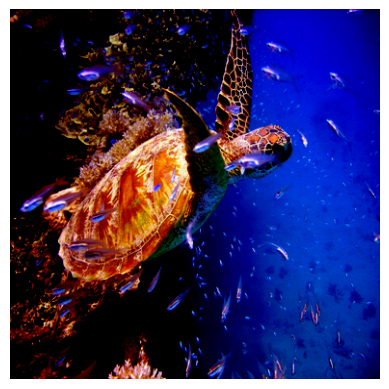

In [5]:
numpy_image = input[1].cpu().detach().squeeze(0).permute(1, 2, 0).numpy()
plt.imshow(numpy_image)
plt.axis('off')
plt.show()

## Test with many Images

In [6]:
folder_dir = "./images"
images = [os.path.join(folder_dir, file_name) for file_name in os.listdir(folder_dir) if file_name.endswith(".JPEG")]

### Without CUDA Graph

In [7]:
count = 0
pred = {}

start_time = time.perf_counter()
# warmup
inputs = feature_extractor(images=Image.open(images[0]), return_tensors="pt")
inputs = inputs['pixel_values'].to(device)
with torch.no_grad():
    for i in range(10):
        outputs = model(inputs).logits
torch.cuda.synchronize()


start_time1 = time.perf_counter()
benchmark_schedule = torch.profiler.schedule(wait=20, warmup=3, active=5, repeat=1)
with torch.no_grad(), torch.profiler.profile(
    schedule=benchmark_schedule,
    on_trace_ready=torch.profiler.tensorboard_trace_handler(f'./log/rtx3080/many_images/no_cuda_graph'),
    record_shapes=True,
) as prof:
       
    for i in range(len(images)):
        with record_function("load_image"):
            input_image = Image.open(images[i])

        with record_function("feature_extractor"):
            # convert image to tensor and put on gpu
            inputs = feature_extractor(images=input_image, return_tensors="pt")
            inputs = inputs['pixel_values'].to(device)

        with torch.no_grad(), record_function("model_inference"):
            # make prediction
            outputs = model(inputs).logits

            with record_function("synchronize"):
                torch.cuda.synchronize()

            with record_function("save_prediction"):
                # add prediction and filename to dictionary
                pred[images[i]] = model.config.id2label[outputs.argmax(-1).item()]

        count += 1
        prof.step()
        
    end_time = time.perf_counter()

print(f"Time: {end_time - start_time1}")
print(f"Time with warmup: {end_time - start_time}")
print("Predicted images:", count)

STAGE:2024-03-13 11:39:22 10537:10537 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-03-13 11:39:22 10537:10537 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-13 11:39:22 10537:10537 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Time: 3.6541966540000885
Time with warmup: 3.779343400000016
Predicted images: 149


In [8]:
# print all predictions
for key, value in pred.items():
    print(f"{key}: {value}", end=", ")
    print()

./images/ILSVRC2012_val_00019101.JPEG: hen, 
./images/ILSVRC2012_val_00042216.JPEG: loggerhead, loggerhead turtle, Caretta caretta, 
./images/ILSVRC2012_val_00015913.JPEG: great grey owl, great gray owl, Strix nebulosa, 
./images/ILSVRC2012_val_00001274.JPEG: goldfinch, Carduelis carduelis, 
./images/ILSVRC2012_val_00011650.JPEG: common newt, Triturus vulgaris, 
./images/ILSVRC2012_val_00005590.JPEG: whiptail, whiptail lizard, 
./images/ILSVRC2012_val_00008816.JPEG: water ouzel, dipper, 
./images/ILSVRC2012_val_00014352.JPEG: loggerhead, loggerhead turtle, Caretta caretta, 
./images/ILSVRC2012_val_00037260.JPEG: electric ray, crampfish, numbfish, torpedo, 
./images/ILSVRC2012_val_00023080.JPEG: spotted salamander, Ambystoma maculatum, 
./images/ILSVRC2012_val_00009938.JPEG: European fire salamander, Salamandra salamandra, 
./images/ILSVRC2012_val_00023438.JPEG: indigo bunting, indigo finch, indigo bird, Passerina cyanea, 
./images/ILSVRC2012_val_00028352.JPEG: bullfrog, Rana catesbeian

### With CUDA Graph

In [9]:
count = 0
pred = {}

static_input = torch.rand(1, 3, 384, 384).to(device)

start_time = time.perf_counter()
# warmup
inputs = feature_extractor(images=Image.open(images[0]), return_tensors="pt")
static_input.copy_(inputs['pixel_values'])

s = torch.cuda.Stream()
s.wait_stream(torch.cuda.current_stream())
with torch.no_grad(), torch.cuda.stream(s):
    for i in range(10):
        static_output = model(static_input).logits
torch.cuda.current_stream().wait_stream(s)
torch.cuda.synchronize()

# capture graph
g = torch.cuda.CUDAGraph()
with torch.cuda.graph(g):
    static_output = model(static_input).logits

torch.cuda.synchronize()

start_time1 = time.perf_counter()
benchmark_schedule = torch.profiler.schedule(wait=20, warmup=3, active=5, repeat=1)
with torch.no_grad(), torch.profiler.profile(
    schedule=benchmark_schedule,
    on_trace_ready=torch.profiler.tensorboard_trace_handler(f'./log/rtx3080/many_images/cuda_graph'),
    record_shapes=True,
) as prof:
    
    for i in range(len(images)):
        with record_function("load_image"):
            input_image = Image.open(images[i])

        with record_function("feature_extractor"):
            # convert image to tensor and copy to gpu
            inputs = feature_extractor(images=input_image, return_tensors="pt")
            static_input.copy_(inputs['pixel_values'])

        with record_function("model_inference"):
            # replay graph
            g.replay()

            with record_function("synchronize"):
                torch.cuda.synchronize()

            with record_function("save_prediction"):
                # add prediction and filename to dictionary
                pred[images[i]] = model.config.id2label[static_output.argmax(-1).item()]
                
        count += 1
        prof.step()

    end_time = time.perf_counter()
    
print(f"Time: {end_time - start_time1}")
print(f"Time with warmup: {end_time - start_time}")
print("Predicted images:", count)

STAGE:2024-03-13 11:39:26 10537:10537 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-03-13 11:39:26 10537:10537 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-13 11:39:26 10537:10537 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Time: 2.9751184159999866
Time with warmup: 3.2660735609999847
Predicted images: 149


In [10]:
# print all predictions
for key, value in pred.items():
    print(f"{key}: {value}", end=", ")
    print()

./images/ILSVRC2012_val_00019101.JPEG: hen, 
./images/ILSVRC2012_val_00042216.JPEG: loggerhead, loggerhead turtle, Caretta caretta, 
./images/ILSVRC2012_val_00015913.JPEG: great grey owl, great gray owl, Strix nebulosa, 
./images/ILSVRC2012_val_00001274.JPEG: goldfinch, Carduelis carduelis, 
./images/ILSVRC2012_val_00011650.JPEG: common newt, Triturus vulgaris, 
./images/ILSVRC2012_val_00005590.JPEG: whiptail, whiptail lizard, 
./images/ILSVRC2012_val_00008816.JPEG: water ouzel, dipper, 
./images/ILSVRC2012_val_00014352.JPEG: loggerhead, loggerhead turtle, Caretta caretta, 
./images/ILSVRC2012_val_00037260.JPEG: electric ray, crampfish, numbfish, torpedo, 
./images/ILSVRC2012_val_00023080.JPEG: spotted salamander, Ambystoma maculatum, 
./images/ILSVRC2012_val_00009938.JPEG: European fire salamander, Salamandra salamandra, 
./images/ILSVRC2012_val_00023438.JPEG: indigo bunting, indigo finch, indigo bird, Passerina cyanea, 
./images/ILSVRC2012_val_00028352.JPEG: bullfrog, Rana catesbeian

prepairing next image, while cpu is idle waiting for gpu to finish prediction

In [11]:
count = 1
pred = {}

static_input = torch.rand(1, 3, 384, 384).to(device)

start_time = time.perf_counter()
# warmup
inputs = feature_extractor(images=Image.open(images[0]), return_tensors="pt")
static_input.copy_(inputs['pixel_values'])

s = torch.cuda.Stream()
s.wait_stream(torch.cuda.current_stream())
with torch.cuda.stream(s):
    for i in range(10):
        static_output = model(static_input).logits
torch.cuda.current_stream().wait_stream(s)
torch.cuda.synchronize()

# capture graph
g = torch.cuda.CUDAGraph()
with torch.cuda.graph(g):
    static_output = model(static_input).logits

torch.cuda.synchronize()

start_time1 = time.perf_counter()
benchmark_schedule = torch.profiler.schedule(wait=20, warmup=3, active=5, repeat=1)
with torch.no_grad(), torch.profiler.profile(
    schedule=benchmark_schedule,
    on_trace_ready=torch.profiler.tensorboard_trace_handler(f'./log/rtx3080/many_images/cuda_graph_next_image'),
    record_shapes=True,
) as prof:

    # load first image
    with record_function("load_image"):
        input_image = Image.open(images[0])

    with record_function("feature_extractor"):
        # convert image to tensor and copy to gpu
        inputs = feature_extractor(images=input_image, return_tensors="pt")
        static_input.copy_(inputs['pixel_values'])

    for i in range(1, len(images)):
        with record_function("model_inference"):
            # replay graph
            g.replay()

            # load next image
            with record_function("load_next_image_and_feature_extractor"):
                input_image = Image.open(images[i])
                inputs = feature_extractor(images=input_image, return_tensors="pt")

            with record_function("synchronize"):
                torch.cuda.synchronize()

            with record_function("save_prediction"):
                # add prediction and filename to dictionary
                pred[count] = model.config.id2label[static_output.argmax(-1).item()]

            with record_function("copy_data"):
                static_input.copy_(inputs['pixel_values'])
                
        count += 1
        prof.step()
    
    # predict last image
    with record_function("model_inference"):
            # replay graph
            g.replay()
    
    with record_function("save_prediction"):
            # add prediction and filename to dictionary
            pred[count] = model.config.id2label[static_output.argmax(-1).item()]

    end_time = time.perf_counter()
    
print(f"Time: {end_time - start_time1}")
print(f"Time with warmup: {end_time - start_time}")
print("Predicted images:", count)

STAGE:2024-03-13 11:39:29 10537:10537 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-03-13 11:39:29 10537:10537 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-13 11:39:29 10537:10537 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Time: 1.8759494949999862
Time with warmup: 2.1983732549999786
Predicted images: 149


In [12]:
# print all predictions
for key, value in pred.items():
    print(f"{key}: {value}", end=", ")
    print()

1: hen, 
2: loggerhead, loggerhead turtle, Caretta caretta, 
3: great grey owl, great gray owl, Strix nebulosa, 
4: goldfinch, Carduelis carduelis, 
5: common newt, Triturus vulgaris, 
6: whiptail, whiptail lizard, 
7: water ouzel, dipper, 
8: loggerhead, loggerhead turtle, Caretta caretta, 
9: electric ray, crampfish, numbfish, torpedo, 
10: spotted salamander, Ambystoma maculatum, 
11: European fire salamander, Salamandra salamandra, 
12: indigo bunting, indigo finch, indigo bird, Passerina cyanea, 
13: bullfrog, Rana catesbeiana, 
14: robin, American robin, Turdus migratorius, 
15: banded gecko, 
16: indigo bunting, indigo finch, indigo bird, Passerina cyanea, 
17: agama, 
18: frilled lizard, Chlamydosaurus kingi, 
19: great grey owl, great gray owl, Strix nebulosa, 
20: electric ray, crampfish, numbfish, torpedo, 
21: leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea, 
22: great grey owl, great gray owl, Strix nebulosa, 
23: beer glass, 
24: vulture, 
25: water

## Profiler to check CUDA Graph capture

In [13]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
    # capture graph
    g = torch.cuda.CUDAGraph()
    with torch.cuda.graph(g):
        static_output = model(static_input).logits

prof.export_chrome_trace(f"log/rtx3080/CUDAGraph_capture_rtx3080.json")

STAGE:2024-03-13 11:39:30 10537:10537 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-03-13 11:39:31 10537:10537 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-13 11:39:31 10537:10537 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
